# Clustering the Physical Activities for a Subject in the "Inactive" Group
Among the 183 subjects, we classified them into three categories based on their daily average steps:
* Inactive: daily average about 1 step.
* Moderately Active: daily average about 4 steps.
* Highly Active: daily average between 7-9 steps

In this notebook, we cluster the activities for a subject in the "Inactive" category.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 9
import datetime as datetime
from dateutil.parser import parse

## Load and Parse the data into Time Series
The individual subjects data have been extracted and stored in a separated folder. This subject data is stored in a file "low1.csv".

In [5]:
dateparse = lambda d: parse(d)
df = pd.read_csv("patients_data/analyses/low1.csv", parse_dates = \
                 ['Datetime'], index_col = "Datetime", date_parser=dateparse)

### What are the unique dates in this subject's timeline? 

In [6]:
np.unique(df.index.date)

array([datetime.date(2016, 6, 22), datetime.date(2016, 6, 23),
       datetime.date(2016, 6, 24), datetime.date(2016, 6, 25),
       datetime.date(2016, 6, 26), datetime.date(2016, 6, 27),
       datetime.date(2016, 6, 28), datetime.date(2016, 6, 29),
       datetime.date(2016, 6, 30), datetime.date(2016, 7, 1),
       datetime.date(2016, 7, 2), datetime.date(2016, 7, 3),
       datetime.date(2016, 7, 4), datetime.date(2016, 7, 5),
       datetime.date(2016, 7, 6), datetime.date(2016, 7, 7),
       datetime.date(2016, 7, 8), datetime.date(2016, 7, 9),
       datetime.date(2016, 7, 10), datetime.date(2016, 7, 11),
       datetime.date(2016, 7, 12), datetime.date(2016, 7, 13),
       datetime.date(2016, 7, 14)], dtype=object)

### What is the earlist time and latest time in the timeline?

In [7]:
print(np.min(df.index))
print ('-' * 10)
print(np.max(df.index))

2016-06-22 09:56:00
----------
2016-07-14 10:56:00


### How many records in total for this patient?

In [8]:
df = df.iloc[:, 2:]
df.shape

(31740, 15)

### In terms of steps, how do the average activities change in a day (0:00-23:00)?

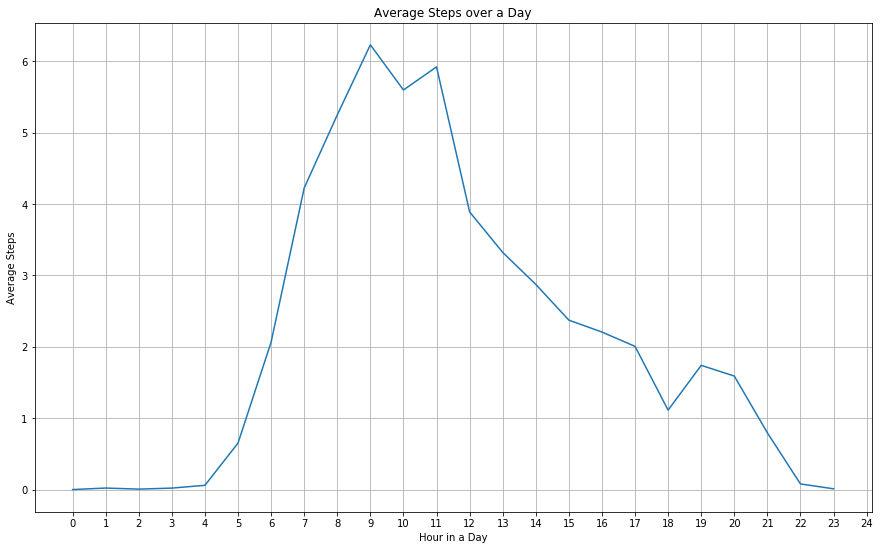

In [9]:
by_time = df[['Steps', 'Hour']].groupby('Hour').mean()
plt.plot(by_time)
plt.title("Average Steps over a Day")
plt.xticks(np.arange(25))
plt.xlabel("Hour in a Day")
plt.ylabel("Average Steps")
plt.grid()

### How do the activity patterns look like in terms of weekdays?

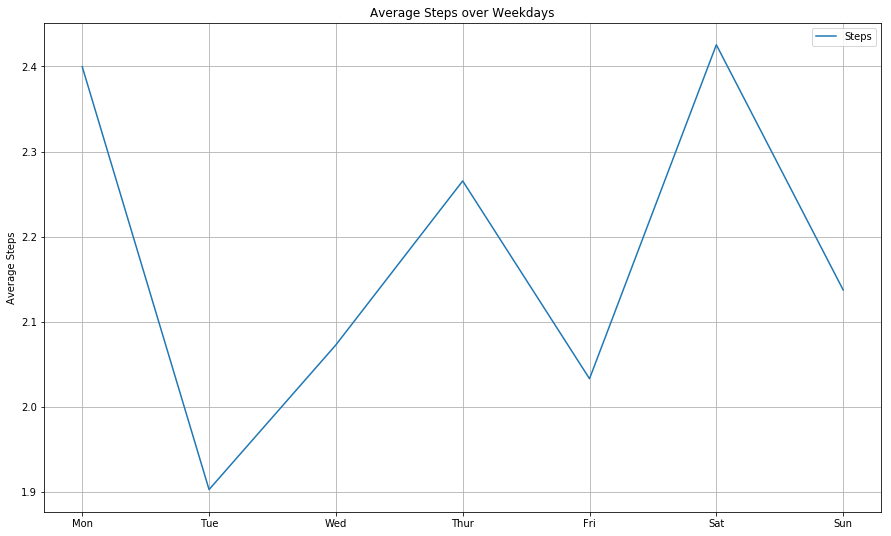

In [10]:
by_weekday = df[['Steps']].groupby(df.index.dayofweek).mean()
xticks = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
by_weekday.index = xticks
by_weekday.plot()
plt.xticks([0,1,2,3,4,5,6], xticks)
plt.ylabel("Average Steps")
plt.title("Average Steps over Weekdays")
plt.grid()

### How do the activity patterns look like in weekdays and weekend?

In [11]:
weekend = np.where(df.index.weekday < 5, 'weekday', 'weekend')
by_time = df.groupby([weekend, 'Hour']).mean()

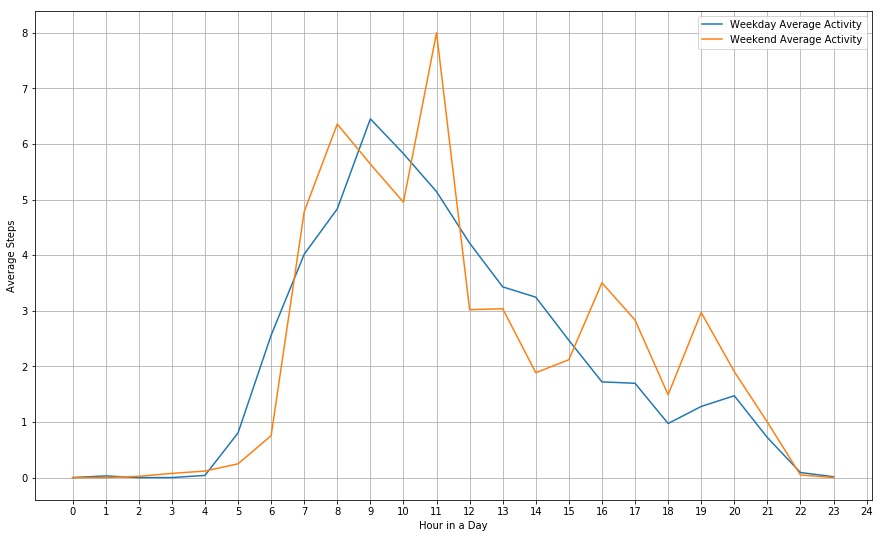

In [12]:
by_time.loc['weekday']['Steps'].plot(label = 'Weekday Average Activity')
by_time.loc['weekend']['Steps'].plot(label = "Weekend Average Activity")
plt.legend()
plt.xlabel("Hour in a Day")
plt.ylabel("Average Steps")
plt.xticks(np.arange(25))
plt.grid()

# Cluster the Activities by 15-minute means

In [13]:
df_15m = df.resample('15T').mean()
df_15m = df_15m[df_15m['WearSens'] == 1]

In [14]:
pd.set_option('display.max_rows', 20)

In [15]:
df_15m.reset_index(inplace = True)

In [16]:
df_15m_data = df_15m[['Steps', 'YCnt', 'XCnt', 'ZCnt', 'Calories', 'VMU', 'WearSens']]

In [17]:
df_15m_data.shape

(1224, 7)

In [18]:
df_15m_data.index

RangeIndex(start=0, stop=1224, step=1)

In [19]:
df_15m_data = df_15m_data[df_15m_data.WearSens == 1]

In [20]:
df_15m_data.shape

(1224, 7)

In [21]:
df_15m_data.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223],
           dtype='int64', length=1224)

In [22]:
df_15m_data = df_15m_data.iloc[:, :-1]
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU
0,11.866667,1995.333333,1639.666667,1471.466667,3.530057,3109.194251
1,0.000000,648.533333,300.733333,359.666667,0.878643,818.710861
2,0.000000,384.933333,149.400000,196.733333,0.515158,470.343028
3,3.666667,1462.133333,878.200000,1219.600000,3.172693,2150.706423
4,14.333333,803.866667,1057.600000,1010.533333,2.237089,1692.192473


In [23]:
df_15m_data.shape

(1224, 6)

In [24]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler().fit(df_15m_data)
scaled = scaler.transform(df_15m_data)
scaled.mean(axis = 0)

array([ 3.77330701e-17,  5.80508771e-18,  1.62542456e-16,  3.48305263e-17,
       -8.70763157e-17, -6.38559648e-17])

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [27]:
hclustering = linkage(scaled, 'ward')

### Cluster the 15-minute mean data into hierarchical clusters. The horizontal line cuts the hierarchical structure into 4 clusters. The numbers at bottom show the number of records in each cluster.

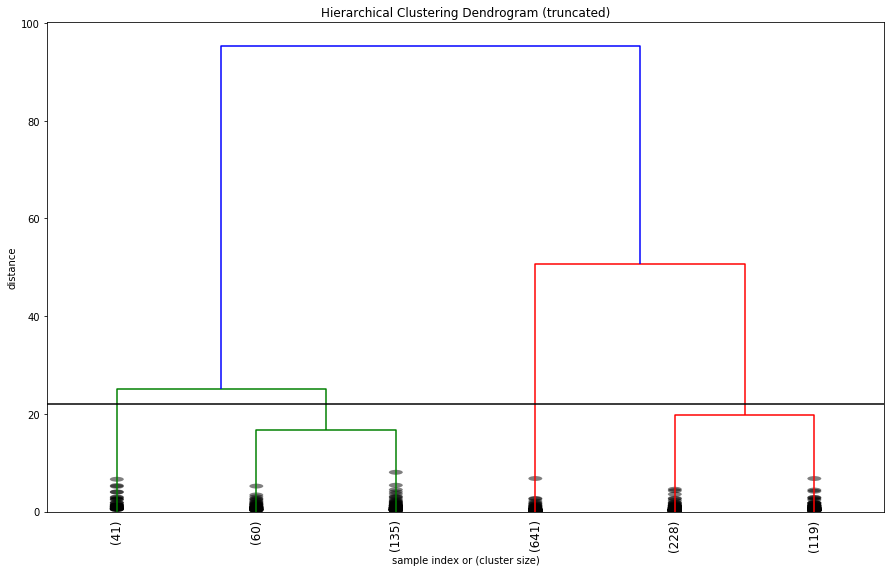

In [28]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    hclustering,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(22, c = 'k')
plt.show()

## Can we cluster the activities into Laying, Sitting, Standing, Walking?

# K-Means Clustering and Visualization

In [29]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

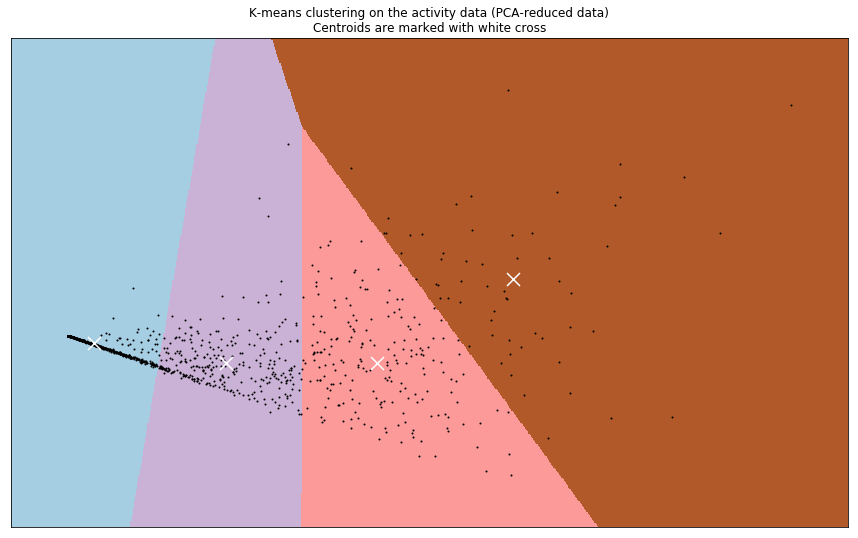

In [30]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(scaled)
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the activity data (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [31]:
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [32]:
kmeans.cluster_centers_

array([[-0.49651687, -0.7454721 , -0.71510788, -0.72672608, -0.75702723,
        -0.74381338],
       [ 0.94366714,  1.36346264,  1.36367592,  1.41133   ,  1.48479447,
         1.4052471 ],
       [-0.05210923,  0.36219525,  0.2320161 ,  0.26700215,  0.31443705,
         0.29988658],
       [ 3.11732239,  2.25529436,  2.62169696,  2.36811524,  2.18624728,
         2.43029906]])

In [33]:
pd.value_counts(kmeans.labels_)

0    672
2    295
1    208
3     49
dtype: int64

In [34]:
centers = kmeans.cluster_centers_
scale_centers = scaler.inverse_transform(centers)

In [35]:
np.set_printoptions(precision=3, suppress = True)
scale_centers

array([[   0.081,  216.811,  140.075,  194.014,    0.367,  341.502],
       [   6.248, 1874.729, 1817.749, 2260.341,    4.578, 3538.226],
       [   1.984, 1087.593,  904.447, 1154.404,    2.38 , 1894.004],
       [  15.555, 2575.834, 2833.03 , 3185.027,    5.896, 5062.989]])

In [45]:
idx = ['Laying', 'Standing', 'Sitting', 'Walking']
cols = ['Steps', 'YCnt', 'XCnt', 'ZCnt', 'Calories', 'VMU']

In [46]:
clusters = pd.DataFrame(scale_centers, index = idx, columns = cols)

## Let's define the patterns of activities

In [47]:
clusters

,Steps,YCnt,XCnt,ZCnt,Calories,VMU
Laying,0.081052,216.810615,140.074802,194.014286,0.366830,341.501901
Standing,6.247756,1874.729167,1817.749038,2260.341026,4.578274,3538.225829
Sitting,1.983955,1087.592542,904.447458,1154.404068,2.379663,1894.003883
Walking,15.555102,2575.834014,2833.029932,3185.027211,5.896011,5062.988930


In [39]:
df_15m_data['label'] = kmeans.labels_
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU,label
0,11.866667,1995.333333,1639.666667,1471.466667,3.530057,3109.194251,1
1,0.000000,648.533333,300.733333,359.666667,0.878643,818.710861,0
2,0.000000,384.933333,149.400000,196.733333,0.515158,470.343028,0
3,3.666667,1462.133333,878.200000,1219.600000,3.172693,2150.706423,2
4,14.333333,803.866667,1057.600000,1010.533333,2.237089,1692.192473,2


In [48]:
lab_act = {0:'Laying', 1:'Standing', 2:'Sitting', 3:'Walking'}
df_15m_data['activity'] = df_15m_data['label'].map(lab_act)

In [49]:
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU,label,activity
0,11.866667,1995.333333,1639.666667,1471.466667,3.530057,3109.194251,1,Standing
1,0.000000,648.533333,300.733333,359.666667,0.878643,818.710861,0,Laying
2,0.000000,384.933333,149.400000,196.733333,0.515158,470.343028,0,Laying
3,3.666667,1462.133333,878.200000,1219.600000,3.172693,2150.706423,2,Sitting
4,14.333333,803.866667,1057.600000,1010.533333,2.237089,1692.192473,2,Sitting


In [50]:
df_15m['activity'] = df_15m_data['activity']
df_15m.head()

,Datetime,Day,Week,Hour,Minute,Steps,Lux,YCnt,XCnt,ZCnt,Calories,VMU,Wear,WearSens,activity
0,2016-06-22 10:15:00,1.0,1.0,10.0,22.0,11.866667,NaN,1995.333333,1639.666667,1471.466667,3.530057,3109.194251,1.0,1.0,Standing
1,2016-06-22 10:30:00,1.0,1.0,10.0,37.0,0.000000,NaN,648.533333,300.733333,359.666667,0.878643,818.710861,1.0,1.0,Laying
2,2016-06-22 10:45:00,1.0,1.0,10.0,52.0,0.000000,NaN,384.933333,149.400000,196.733333,0.515158,470.343028,1.0,1.0,Laying
3,2016-06-22 11:00:00,1.0,1.0,11.0,7.0,3.666667,NaN,1462.133333,878.200000,1219.600000,3.172693,2150.706423,1.0,1.0,Sitting
4,2016-06-22 11:15:00,1.0,1.0,11.0,22.0,14.333333,NaN,803.866667,1057.600000,1010.533333,2.237089,1692.192473,1.0,1.0,Sitting


## Visualize the activity patterns 

In [51]:
act_groups = df_15m.groupby(['Hour', 'activity']).count()[['Steps']]

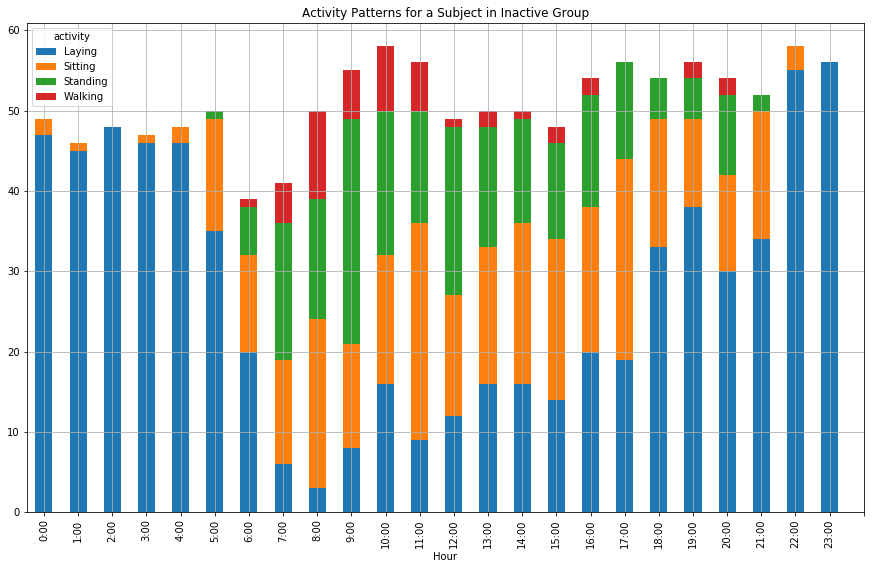

In [52]:
act_groups.unstack()['Steps'].plot(kind = "bar", stacked = True)
plt.xticks(np.arange(25), ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', \
                          '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', \
                          '21:00', '22:00', '23:00'])
plt.title("Activity Patterns for a Subject in Inactive Group")
plt.grid()